# Machine Learning - Forecast of hydroelectric production in Portugal
Optimisation des systèmes énergétiques - 2022  
Alexandre Castanié

---

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import xgboost as xgb
import plotly.express as px
import seaborn as sns
from NBEATS import NeuralBeats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from darts.models import NBEATSModel
from darts.utils.likelihood_models import QuantileRegression
from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics.metrics import coefficient_of_variation

### Importing and preparing data
---

In [2]:
def index_datetime(df):
    df=df.set_index('Date')
    df.index=pd.to_datetime(df.index,format="%d/%m/%Y")
    return df

In [3]:
df_TA=pd.read_csv('TA_tab.csv',sep=';',usecols=['Date','PT11','PT15','PT16','PT17','PT18'])
df_TA=index_datetime(df_TA)
df_TA.rename(columns={'PT11':'TA PT11','PT15':'TA PT15','PT16':'TA PT16','PT17':'TA PT17','PT18':'TA PT18'},inplace=True)
df_TP=pd.read_csv('TP_tab.csv',sep=';',usecols=['Date','PT11','PT15','PT16','PT17','PT18'])
df_TP=index_datetime(df_TP)
df_TP.rename(columns={'PT11':'TP PT11','PT15':'TP PT15','PT16':'TP PT16','PT17':'TP PT17','PT18':'TP PT18'},inplace=True)
df_load=pd.read_csv('load.csv',sep=';',usecols=['Datetime','PT'])
df_load=df_load.set_index('Datetime')
df_load.index=pd.to_datetime(df_load.index,utc=True)
df_HRO=pd.read_csv('HRO_tab.csv',sep=';',usecols=['Date','PT'])
df_HRO=index_datetime(df_HRO)
df_HRO.rename(columns={'PT':'CF_HRO'},inplace=True)
df_HRE=pd.read_csv('HRE_tab.csv',sep=';',usecols=['Date','PT'])
df_HRE=index_datetime(df_HRE)
df_HRE.rename(columns={'PT':'CF_HRE'},inplace=True)

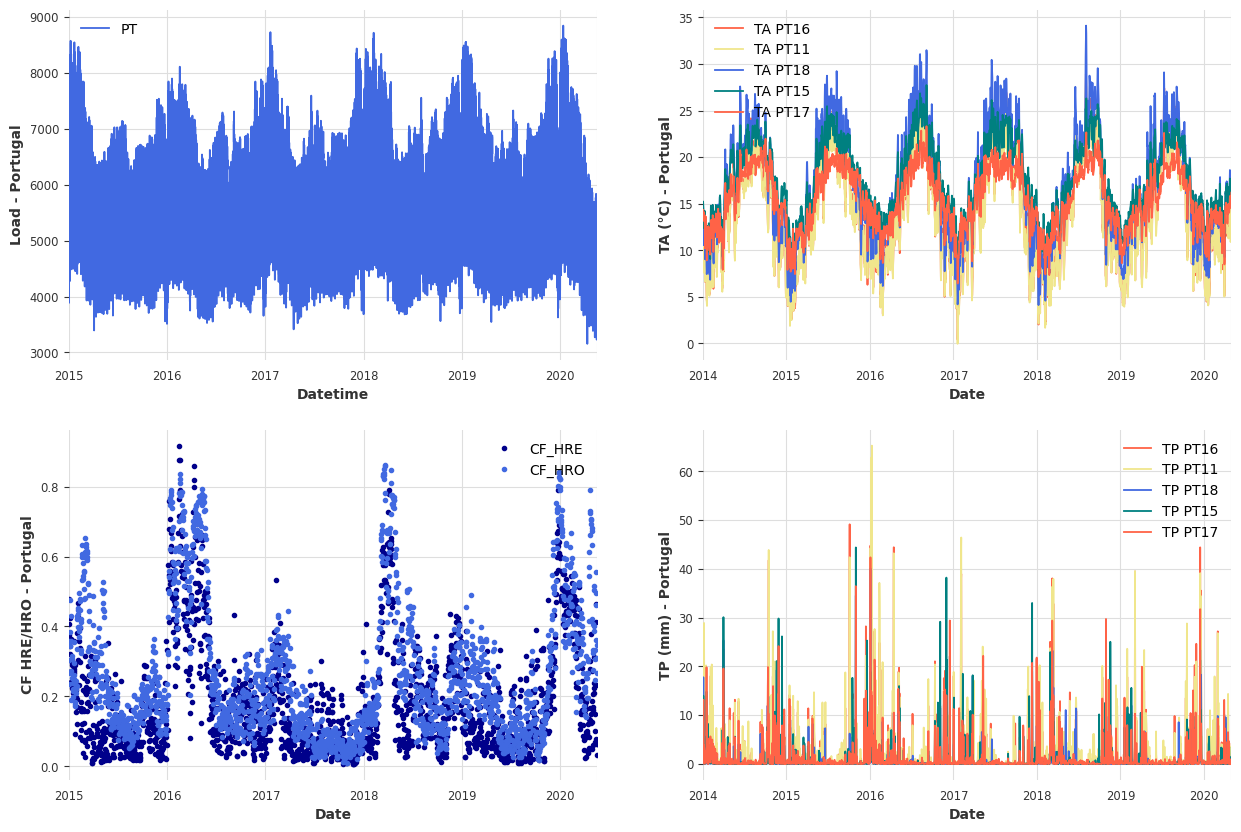

In [4]:
fig,axs=plt.subplots(2,2,figsize=(15,10))
df_load.plot(ax=axs[0,0],ylabel='Load - Portugal', color='royalblue')
df_HRE.plot(ax=axs[1,0], c='DarkBlue', label='HRE',style='.')
df_HRO.plot(ax=axs[1,0], ylabel='CF HRE/HRO - Portugal',label='HRO',style='.',color='royalblue')
df_TA.plot(ax=axs[0,1],ylabel='TA (°C) - Portugal',color=['tomato','khaki','royalblue','teal'])
df_TP.plot(ax=axs[1,1],ylabel='TP (mm) - Portugal',color=['tomato','khaki','royalblue','teal'])
plt.show()

The load data are hourly while the temperature (TA), precipitation (TP) and production (CF HRE or CF HRO) data are daily. In order to compare them, it is therefore necessary to average the load data by day.

In [5]:
df_avgload=df_load.resample('D').mean()
df_avgload.rename(columns={'PT':'Average load'},inplace=True)

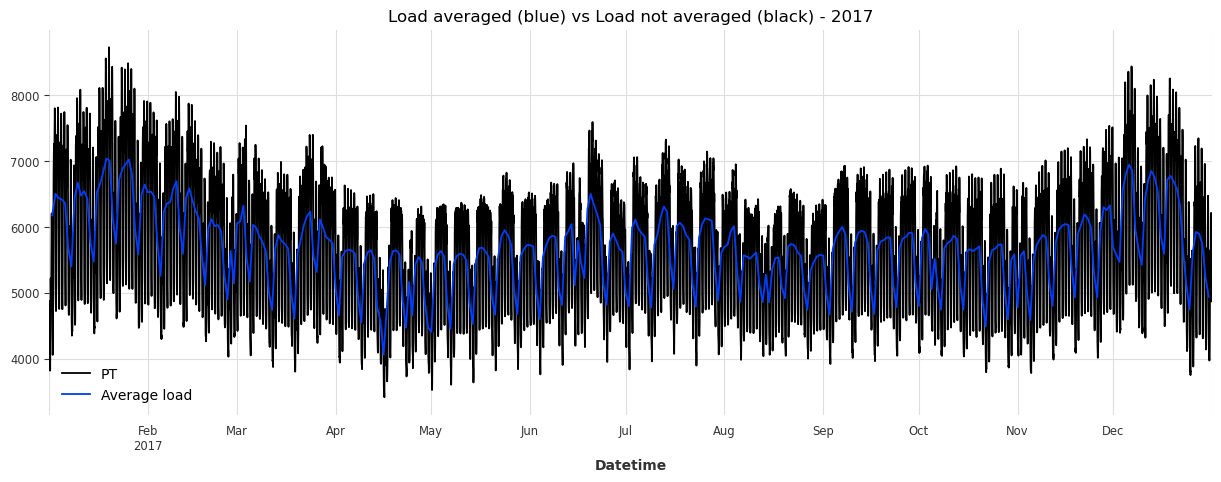

In [6]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
df_load.loc[(df_load.index>'2017-01-01')&(df_load.index<'2018-01-01')].plot(ax=ax,title='Load averaged (blue) vs Load not averaged (black) - 2017')
df_avgload.loc[(df_avgload.index>'2017-01-01')&(df_avgload.index<'2018-01-01')].plot(ax=ax)
plt.show()

In [7]:
# fig=px.line(df_load,y=['PT'])
# fig.add_scatter(x=df_avgload.index,y=df_avgload['PT'])
# fig.show()

CF HRO represents the run-of-river hydroelectric generation of Portugal from January 1, 2015 to May 18, 2020. Let's run a train/test split with different algorithms and compare their performance.  

### Outliers
---

<u> Seasonal decomposition of CF HRO

Text(0, 0.5, 'Residual')

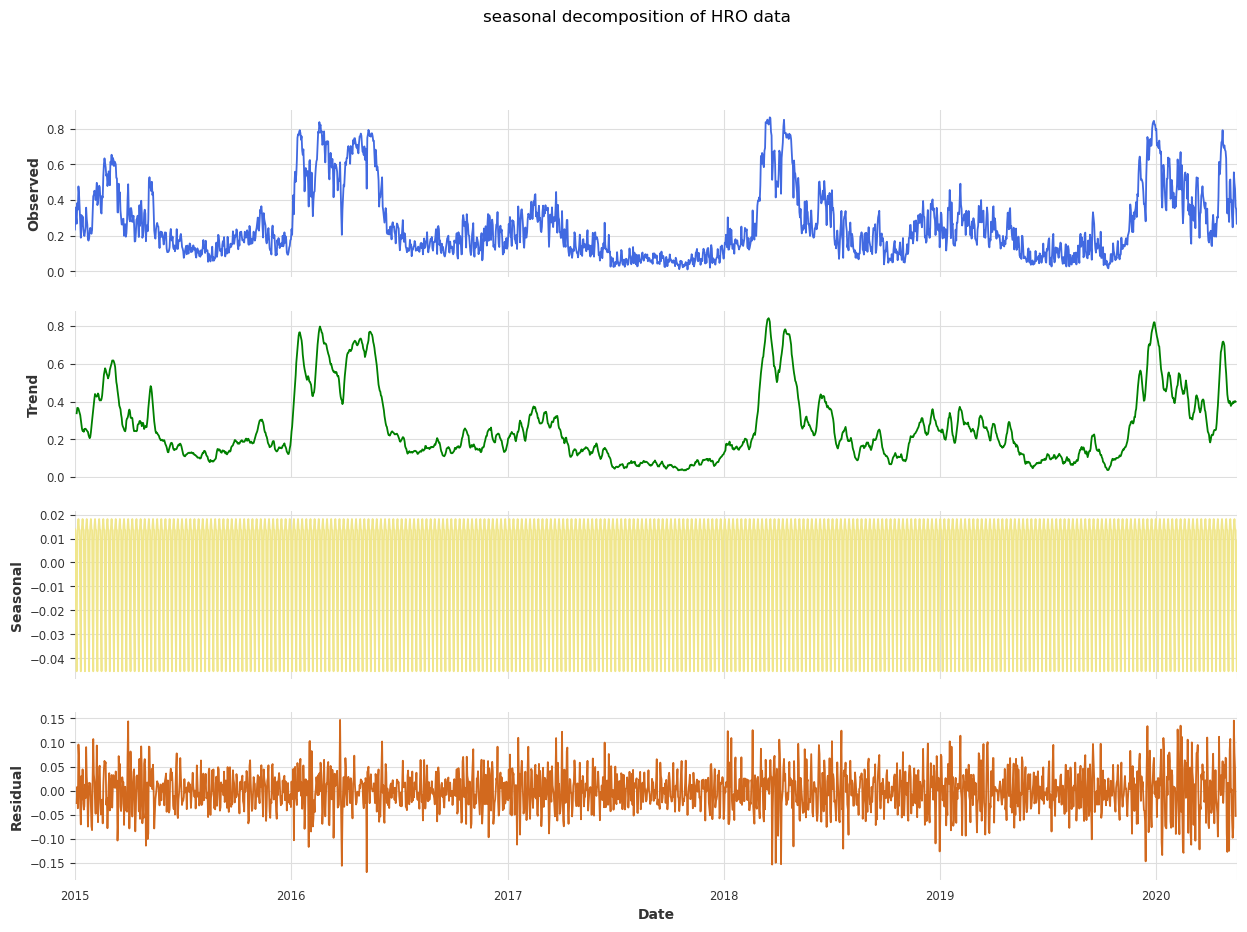

In [8]:
decomposition = seasonal_decompose(df_HRO,model='additive')
fig, axes = plt.subplots(4, 1, sharex=True,figsize=(15,10))

fig.suptitle('seasonal decomposition of HRO data')
decomposition.observed.plot(ax=axes[0], legend=False, color='royalblue')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False,color='khaki')
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='chocolate')
axes[3].set_ylabel('Residual')

In [9]:
df_HRO.describe()

,CF_HRO
count,1965.000000
mean,0.261450
std,0.194154
min,0.010521
25%,0.121022
50%,0.199482
75%,0.341204
max,0.862696


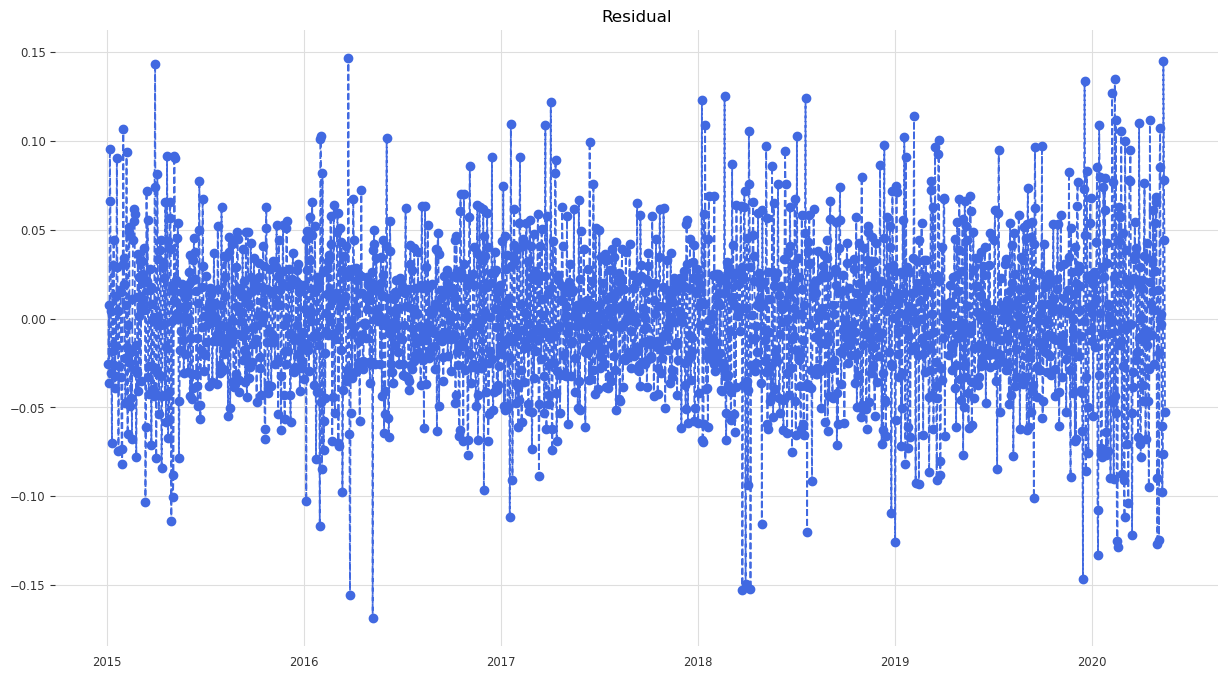

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
x = decomposition.resid.index
y = decomposition.resid.values

ax.plot_date(x, y,linestyle='--',color='royalblue')
ax.set_title('Residual')
plt.show()

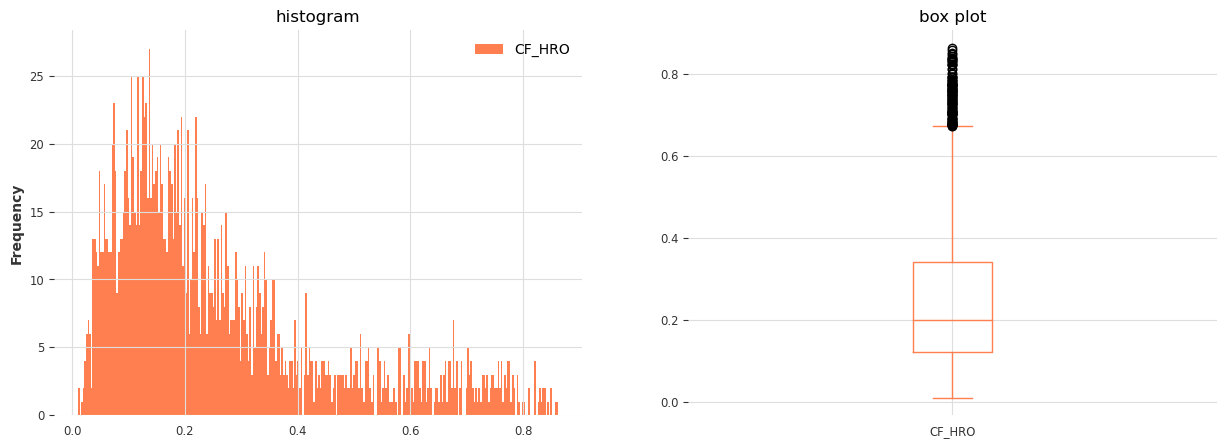

In [11]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
df_HRO.plot(kind='hist',bins=300,ax=ax[0],title='histogram',color='coral')
df_HRO.plot(kind='box',ax=ax[1], title='box plot',color='coral')
plt.show()

The data have some outliers : some values are a little bit too far from the mean value. However, these values represent a peak in production that occurs every two years, so we cannot remove them.

### Features
---

<u> Feature and lag creation

In [12]:
features=['day of the week','quarter','month','year','day of the year','day','TA PT16','TP PT16','Average load']

In [13]:
def add_features(df):

    df=df.copy()
    df['day of the week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day of the year'] = df.index.dayofyear
    df['day'] = df.index.day
    try:
        #del df['jours fériés']
        del df['TA PT16']
        del df['TP PT16']
        del df['Average load']
    except:
        pass
    #df = df.merge(joursferies[['jours fériés']],how='left', left_index=True, right_index=True)
    df = df.merge(df_TA[['TA PT16']],how='left', left_index=True, right_index=True)
    df = df.merge(df_TP[['TP PT16']],how='left', left_index=True, right_index=True)
    df = df.merge(df_avgload.tz_localize(None),how='left', left_index=True, right_index=True)

    return df

In [14]:
def add_lags(df):
    target_map = df['CF HRO'].to_dict()
    try:
        del df['lag1']
        del df['lag2']
        del df['lag3']
    except:
        pass
    df['lag1'] = (df.index - pd.Timedelta('182 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('546 days')).map(target_map)
    return df

<u> Correlations with features

In [43]:
df_HRO=add_features(df_HRO).fillna(0)

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, 'Pair Plot of production, load, temperature and precipitation data')

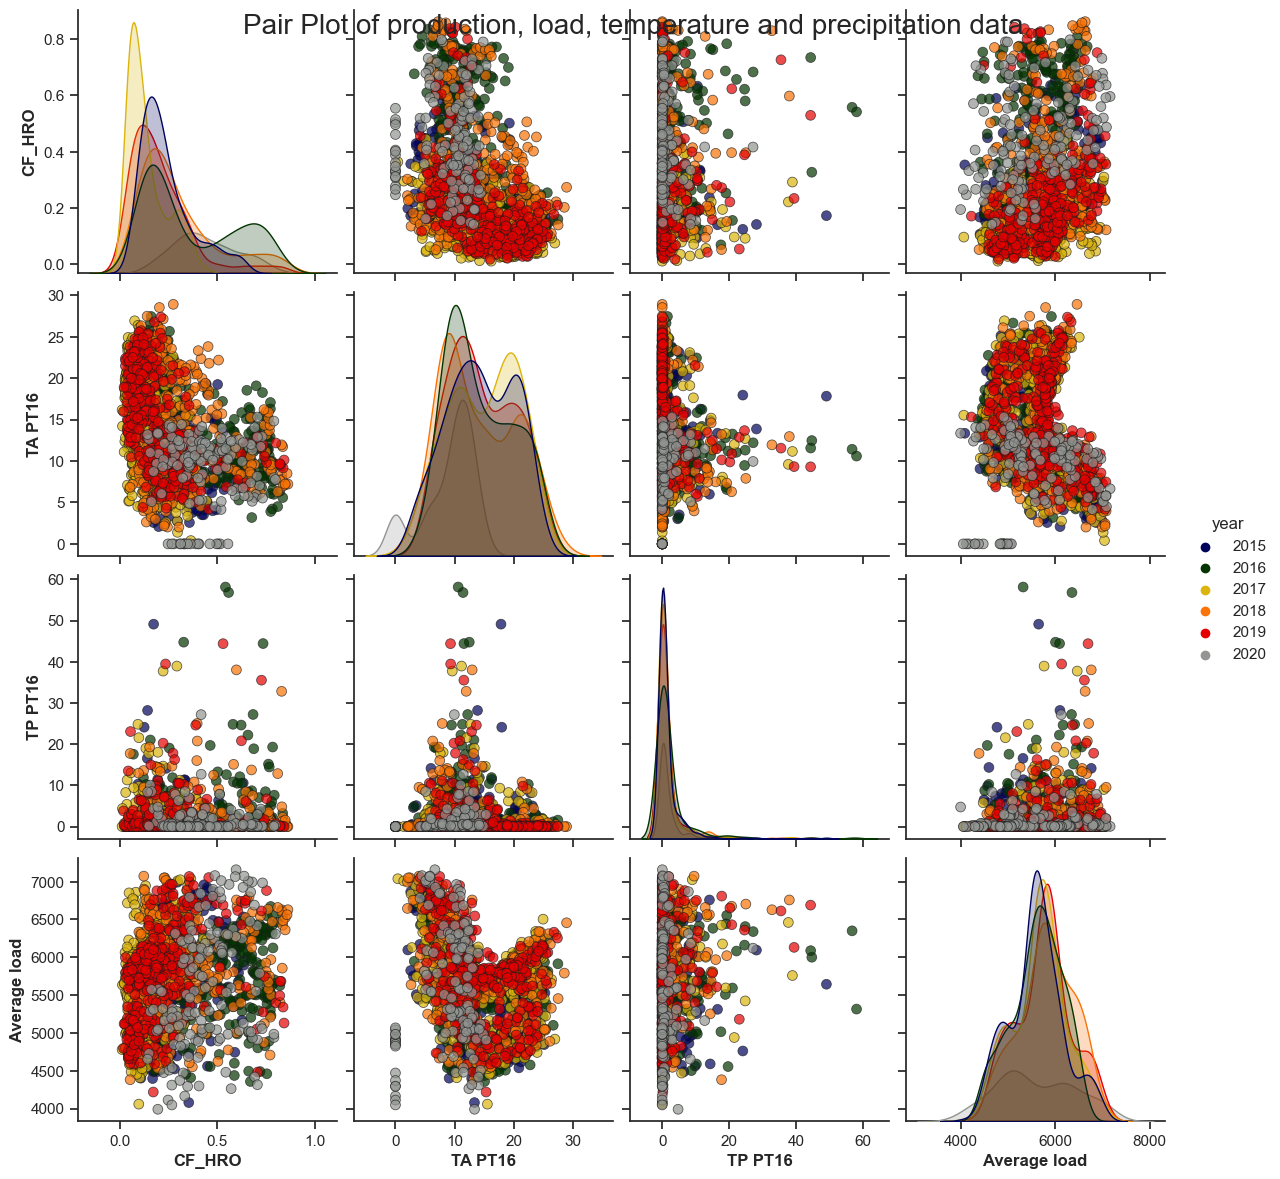

In [44]:
sns.set(style="ticks", color_codes=True)

# Create a custom color palete
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold','orange','red','grey'])

# Make the pair plot with a some aesthetic changes
sns.pairplot(df_HRO[['CF_HRO','TA PT16','TP PT16','Average load','year']],
            diag_kind = 'kde', hue='year',
            palette=palette,
            plot_kws = {'alpha': 0.7,'s':50,'edgecolor':'k'},
            size=3,
            #diag_kws=dict(shade=True)
            ) 
plt.suptitle('Pair Plot of production, load, temperature and precipitation data', size = 20)

### Split
---

In [45]:
tssplit=TimeSeriesSplit(n_splits=2, test_size=139)
for train_index,test_index in tssplit.split(df_HRO):
    train=df_HRO[['CF_HRO']+features].iloc[train_index]
    test=df_HRO[['CF_HRO']+features].iloc[test_index]

<AxesSubplot:title={'center':'train/ test split on data'}, xlabel='Date', ylabel='CF HRO'>

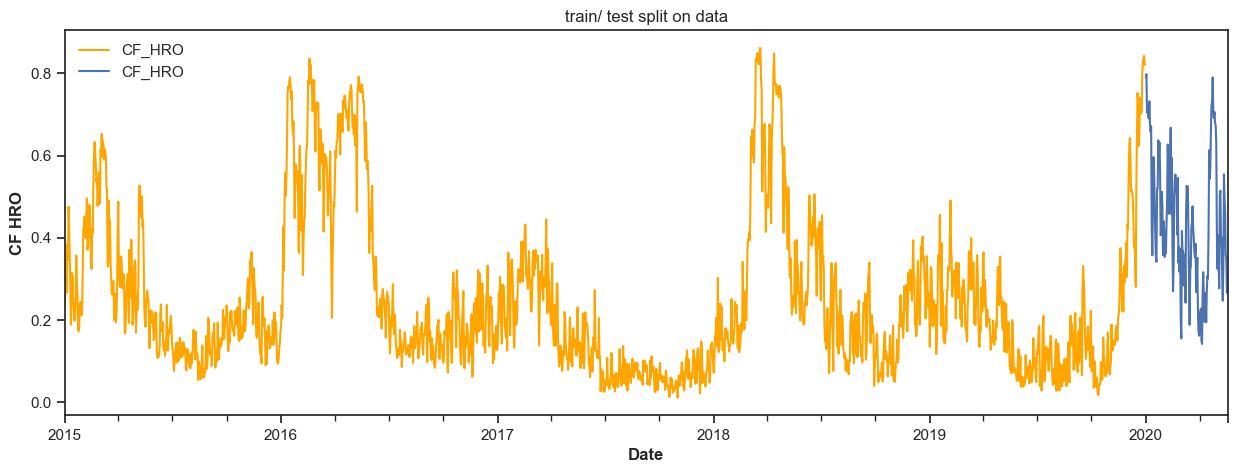

In [46]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
train[['CF_HRO']].plot(ax=ax,ylabel='CF HRO',title='train/ test split on data',color='orange')
test[['CF_HRO']].plot(ax=ax)

In [47]:
X_train = train[features]
y_train = train['CF_HRO']
X_test = test[features]
y_test = test['CF_HRO']

### Models used
---

3 models will be used: random forest, xgboost and nbeats. xg boost works by gradient boosting while nbeats is based on a neural network architecture.

- Ranfom Forest : The algorithm is based on decision trees, which are simple models that can handle non-linear relationships between features and target variables. In a Random Forest, multiple decision trees are trained on random subsets of the training data and features. The final prediction made by the Random Forest is the average of the predictions made by all the individual decision trees. This combination of multiple simple models results in a more robust and accurate prediction compared to a single decision tree. One of the key strengths of the Random Forest algorithm is its ability to handle high dimensional data with a large number of features. This is because each decision tree only uses a subset of the features at each split, which helps to reduce overfitting. The Random Forest algorithm also has built-in feature selection and variable importance measures, which can be used to identify the most important features in a dataset. Another advantage of the Random Forest algorithm is its interpretability. Unlike many deep learning algorithms, decision trees are simple models that can be visualized and understood by humans.

- XGBoost : It stands for "Extreme Gradient Boosting" and is based on the gradient boosting algorithm. Gradient Boosting is a boosting algorithm that combines multiple weak learners to create a strong learner. The algorithm starts by training a weak model on the data, and then iteratively trains subsequent models to correct the mistakes made by the previous models. The final model is a weighted sum of the weak models, where the weights are determined by the gradient of a loss function with respect to the model predictions. XGBoost extends the traditional gradient boosting algorithm in several ways. Firstly, XGBoost uses decision trees as its base learner, which allows it to handle non-linear relationships between the features and target variable. Secondly, XGBoost includes several optimizations such as parallel processing, regularization, and feature selection techniques that make the algorithm more efficient and effective. In summary, XGBoost is a highly effective machine learning algorithm that combines the strengths of gradient boosting and decision trees to achieve excellent performance on both regression and classification tasks.

- Nbeats : Unlike traditional recurrent neural network (RNN) models, NBEATS uses a block-based architecture to model and predict time series data. The algorithm consists of two main blocks: the forecasting block and the attention block. The forecasting block generates predictions using the historical data of the time series, while the attention block selects the most relevant information from the historical data to feed into the predictions. NBEATS is capable of multi-step time series forecasting, meaning it can predict multiple future steps at once, making it a particularly useful algorithm for long-term forecasting tasks.

### Hyperparameters tuning
---

In [83]:
GridsearchXGBparams =  {
  #"objective"           : "reg:squarederror",
  #"eval_metric"         : "rmse",
  "eta"                 : [0.01,0.2,0.3,0.5,0.6],
  "max_depth"           : [6,8,9,10],
  #"min_child_weight"    : 0,
  #"max_delta_step"      : 1000,
  #"gamma"               : 0.0,
  "subsample"           : np.arange(0.5, 1.0, 0.1),
  #"sampling_method"     :'uniform',
  "colsample_bytree"    : np.arange(0.5, 1.0, 0.1),
  #"reg_alpha"           : 0,
  #"reg_lambda"          : 0,
  #'tree_method'         : 'hist',
  'base_score'          : np.arange(0.5, 1.0, 0.1),
  #'early_stopping_rounds' : 50,
  #'booster'             : 'gbtree',
  'n_estimators'        : [400,600,800,1000]
}

GridsearchRFparams = {
#'bootstrap': False,
 #'criterion': 'squared_error',
 'max_depth': [6,7,8,9],
 'max_features': ['auto', 'sqrt'],
 #'max_leaf_nodes': None,
 #'min_impurity_decrease': 0.0,
 #'min_impurity_split': None,
 'min_samples_leaf': np.arange(1, 5, 1),
 'min_samples_split': np.arange(2, 10, 2),
 #'min_weight_fraction_leaf': 0.0,
 'n_estimators': [200,400,800,900],
 #'n_jobs': 1,
 #'oob_score': False,
 #'random_state': 42,
 #'verbose': 0,
 #'warm_start': False
 }

GridsearchNBparams = {
'input_chunk_length' : [20, 30],
'output_chunk_length': [1], 
'num_stacks':[32,64],
'layer_widths':[16,32,48],
'batch_size':[64,128, 256],
'n_epochs': [10,20,30],
#'nr_epochs_val_period':1, 
#'likelihood':QuantileRegression([0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]), 
#'optimizer_kwargs': {"lr": 1e-3},
#'log_tensorboard':True,
#'generic_architecture':True, 
'random_state': [21,42,63],
#'force_reset':True,
#'save_checkpoints':True
}

<u> Random forest model

In [116]:
start=time.time()
rf= RandomForestRegressor()
clf_rf = RandomizedSearchCV(estimator=rf,
                         param_distributions=GridsearchRFparams,
                         scoring='neg_mean_squared_error',
                         n_iter=100,
                         verbose=0,
                         error_score='raise')
                         
clf_rf.fit(X_train, y_train)

print(f"Best parameters: {clf_rf.best_params}")
print(f"Lowest RMSE: {(-clf_rf.best_score_)**(1/2.0)}")
print(f"execution time : {time.ctime(time.time() - start)[11:19]}")

Best parameters: {'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8}
Lowest RMSE:  0.20833199496471533


<u> XGBoost model

In [119]:
start=time.time()
xgbr = xgb.XGBRegressor()
clf_xgb= RandomizedSearchCV(estimator=xgbr,
                         param_distributions=GridsearchXGBparams,
                         scoring='neg_mean_squared_error',
                         n_iter=100,
                         verbose=0,
                         error_score='raise')
                         
clf_xgb.fit(X_train, y_train)

print(f"Best parameters: {clf_xgb.best_params}")
print(f"Lowest RMSE: {(-clf_xgb.best_score_)**(1/2.0)}")
print(f"execution time : {time.ctime(time.time() - start)[11:19]}")

Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 400, 'max_depth': 9, 'eta': 0.01, 'colsample_bytree': 0.5, 'base_score': 0.6}
Lowest RMSE:  0.2089445640252976


<u> Nbeats model

In [100]:
ts_train = TimeSeries.from_series(pd.to_numeric(y_train))
ts_test = TimeSeries.from_series(pd.to_numeric(y_test))
covariates = TimeSeries.from_dataframe(pd.concat([X_train,X_test]).astype(np.float64))

scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train).astype(np.float64)
ts_ttest = scalerP.transform(ts_test).astype(np.float64)

scalerF = Scaler()
scalerF.fit_transform(covariates)
pcovariates = scalerF.transform(covariates).astype(np.float64)

In [86]:
start=time.time()

clf_nb = NBEATSModel.gridsearch(parameters=GridsearchNBparams,series=ts_ttrain,val_series=ts_ttest, past_covariates=pcovariates,
metric=coefficient_of_variation,verbose=False,n_random_samples=0.1)

print(f"Best parameters: {clf_nb}")
print(f"execution time : {time.ctime(time.time() - start)[11:19]}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 245 K 
---------------------------------------------------
243 K     Trainable params
1.9 K     Non-trainable params
245 K     Total params
1.961     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 490 K 
---------------------------------------------------
488 K     Trainable params
1.9 K     Non-trainable params
490 K     Total params
3.923     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 590 K 
---------------------------------------------------
589 K     Trainable params
1.4 K     Non-trainable params
590 K     Total params
4.724     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 245 K 
---------------------------------------------------
243 K     Trainable params
1.9 K     Non-trainable params
245 K     Total params
1.961     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 959 K 
---------------------------------------------------
957 K     Trainable params
2.0 K     Non-trainable params
959 K     Total params
7.675     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 763 K 
---------------------------------------------------
761 K     Trainable params
2.0 K     Non-trainable params
763 K     Total params
6.107     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 245 K 
---------------------------------------------------
243 K     Trainable params
1.9 K     Non-trainable params
245 K     Total params
1.961     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.2 M 
---------------------------------------------------
1.2 M     Trainable params
1.4 K     Non-trainable params
1.2 M     Total params
9.448     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 174 K 
---------------------------------------------------
173 K     Trainable params
1.3 K     Non-trainable params
174 K     Total params
1.398     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 716 K 
---------------------------------------------------
714 K     Trainable params
1.4 K     Non-trainable params
716 K     Total params
5.729     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 490 K 
---------------------------------------------------
488 K     Trainable params
1.9 K     Non-trainable params
490 K     Total params
3.923     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 490 K 
---------------------------------------------------
488 K     Trainable params
1.9 K     Non-trainable params
490 K     Total params
3.923     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 174 K 
---------------------------------------------------
173 K     Trainable params
1.3 K     Non-trainable params
174 K     Total params
1.398     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.2 M 
---------------------------------------------------
1.2 M     Trainable params
1.4 K     Non-trainable params
1.2 M     Total params
9.448     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 174 K 
---------------------------------------------------
173 K     Trainable params
1.3 K     Non-trainable params
174 K     Total params
1.398     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 358 K 
---------------------------------------------------
356 K     Trainable params
1.4 K     Non-trainable params
358 K     Total params
2.865     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.5 M 
---------------------------------------------------
1.5 M     Trainable params
2.0 K     Non-trainable params
1.5 M     Total params
12.213    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 174 K 
---------------------------------------------------
173 K     Trainable params
1.3 K     Non-trainable params
174 K     Total params
1.398     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 490 K 
---------------------------------------------------
488 K     Trainable params
1.9 K     Non-trainable params
490 K     Total params
3.923     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 763 K 
---------------------------------------------------
761 K     Trainable params
2.0 K     Non-trainable params
763 K     Total params
6.107     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 490 K 
---------------------------------------------------
488 K     Trainable params
1.9 K     Non-trainable params
490 K     Total params
3.923     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 959 K 
---------------------------------------------------
957 K     Trainable params
2.0 K     Non-trainable params
959 K     Total params
7.675     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 490 K 
---------------------------------------------------
488 K     Trainable params
1.9 K     Non-trainable params
490 K     Total params
3.923     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.2 M 
---------------------------------------------------
1.2 M     Trainable params
1.4 K     Non-trainable params
1.2 M     Total params
9.448     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 763 K 
---------------------------------------------------
761 K     Trainable params
2.0 K     Non-trainable params
763 K     Total params
6.107     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 349 K 
---------------------------------------------------
348 K     Trainable params
1.3 K     Non-trainable params
349 K     Total params
2.797     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 245 K 
---------------------------------------------------
243 K     Trainable params
1.9 K     Non-trainable params
245 K     Total params
1.961     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 479 K 
---------------------------------------------------
477 K     Trainable params
2.0 K     Non-trainable params
479 K     Total params
3.837     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 716 K 
---------------------------------------------------
714 K     Trainable params
1.4 K     Non-trainable params
716 K     Total params
5.729     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 349 K 
---------------------------------------------------
348 K     Trainable params
1.3 K     Non-trainable params
349 K     Total params
2.797     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.5 M 
---------------------------------------------------
1.5 M     Trainable params
2.0 K     Non-trainable params
1.5 M     Total params
12.213    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.5 M 
---------------------------------------------------
1.5 M     Trainable params
2.0 K     Non-trainable params
1.5 M     Total params
12.213    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Best parameters: (<darts.models.forecasting.nbeats.NBEATSModel object at 0x000001FA8BBC2160>, {'input_chunk_length': 30, 'output_chunk_length': 1, 'num_stacks': 64, 'layer_widths': 48, 'batch_size': 128, 'n_epochs': 30, 'random_state': 63}, 31.571095153974003)
execution time : 01:26:32


### Training 
---

<u> Random Forest

In [87]:
start=time.time()
regRF=RandomForestRegressor(criterion='squared_error',
                            max_depth= 8,
                            max_features='sqrt',
                            #'max_leaf_nodes': None,
                            #'min_impurity_decrease': 0.0,
                            #'min_impurity_split': None,
                            min_samples_leaf= 4,
                            min_samples_split= 4,
                            #'min_weight_fraction_leaf': 0.0,
                            n_estimators= 400
                            )

regRF.fit(X_train, y_train)

y_predRF= regRF.predict(X_test.fillna(0))
print(f"RMSE score Random forest = {np.sqrt(mean_squared_error(y_test, y_predRF))} \nexecution time : {time.ctime(time.time() - start)[11:19]}")

RMSE score Random forest = 0.23583180143889876 
execution time : 01:00:00


<u> XGBoost

In [89]:
start=time.time()
regXGB=xgb.XGBRegressor(objective="reg:squarederror",
                     eval_metric="rmse",
                     eta=0.01,
                     max_depth=9,
                     #min_child_weight=0,
                     #max_delta_step=0,
                     #gamma=0.0,
                     subsample=0.9,
                     sampling_method='uniform',
                     colsample_bytree=0.5,
                     #reg_alpha=0,
                     #reg_lambda=1,
                     tree_method='hist',
                     booster='gbtree',
                     n_estimators=400,
                     base_score=0.6
                     )

regXGB.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

y_predXGB= regXGB.predict(X_test)
print(f"RMSE score XGboost = {np.sqrt(mean_squared_error(y_test, y_predXGB))} \nexecution time : {time.ctime(time.time() - start)[11:19]}")

RMSE score XGboost = 0.22029455282092247 
execution time : 01:00:01


<u> Nbeats

In [115]:
start=time.time()
nbeats = NBEATSModel(   input_chunk_length= 30,
                        output_chunk_length=1, 
                        num_stacks=64,
                        layer_widths=48,
                        batch_size=128,
                        n_epochs=30,
                        #nr_epochs_val_period=1, 
                        #likelihood=QuantileRegression(QUANTILES), 
                        optimizer_kwargs={"lr": 1e-3},
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=63,
                        force_reset=True,
                        save_checkpoints=True
                    )

nbeats.fit(series=ts_ttrain, val_series=ts_ttest,verbose=False, past_covariates=pcovariates,val_past_covariates=pcovariates)

print(f"execution time : {time.ctime(time.time() - start)[11:19]}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1595: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=30` reached.


execution time : 01:02:03


In [116]:
y_predNB=nbeats.predict(n=len(ts_ttest),verbose=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Results
---

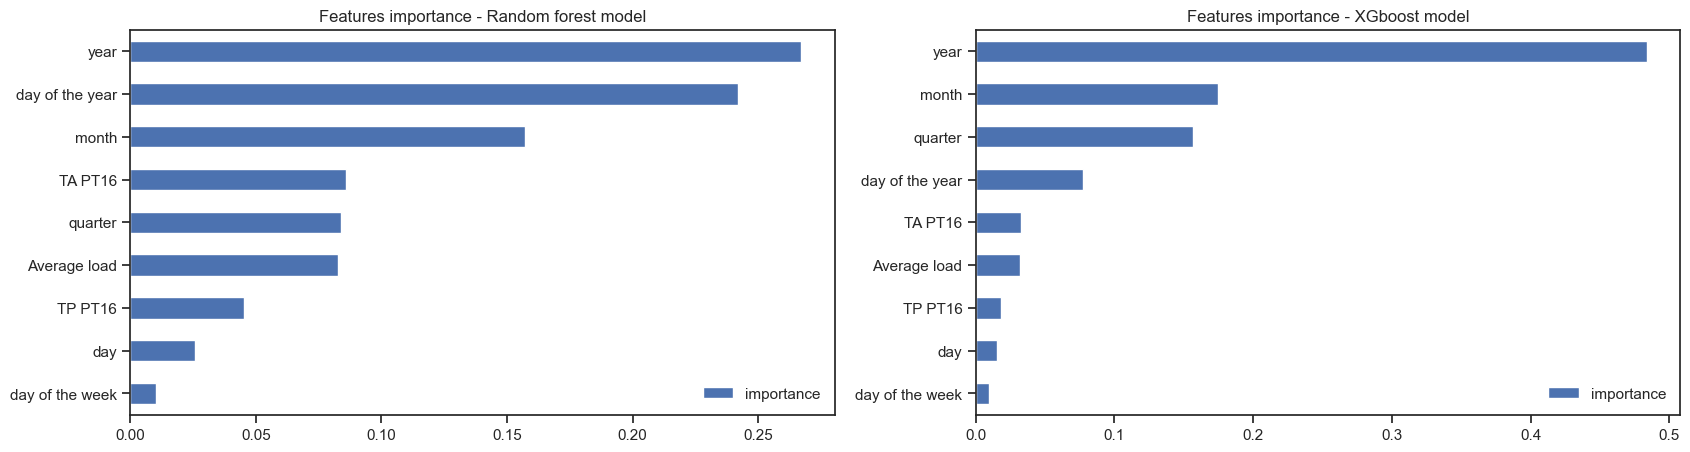

In [104]:
FI_XGB = pd.DataFrame(data=regXGB.feature_importances_, index=features, columns=['importance'])
FI_RF = pd.DataFrame(data=regRF.feature_importances_, index=features, columns=['importance'])

fig,ax=plt.subplots(1,2,figsize=(20,5))
FI_RF.sort_values('importance').plot(kind='barh', title='Features importance - Random forest model',ax=ax[0])
FI_XGB.sort_values('importance').plot(kind='barh', title='Features importance - XGboost model',ax=ax[1])
plt.show()

In [117]:
results=pd.merge(y_test,pd.DataFrame(y_predRF,index=y_test.index,columns=['Random forest prediction']),
how='left',left_index=True,right_index=True)
results=pd.merge(results,pd.DataFrame(y_predXGB,index=y_test.index,columns=['XGboost prediction']),
how='left',left_index=True,right_index=True)
results=pd.merge(results,pd.DataFrame(y_predNB.pd_series(),index=y_test.index,columns=['NBeats prediction']),
how='left',left_index=True,right_index=True)

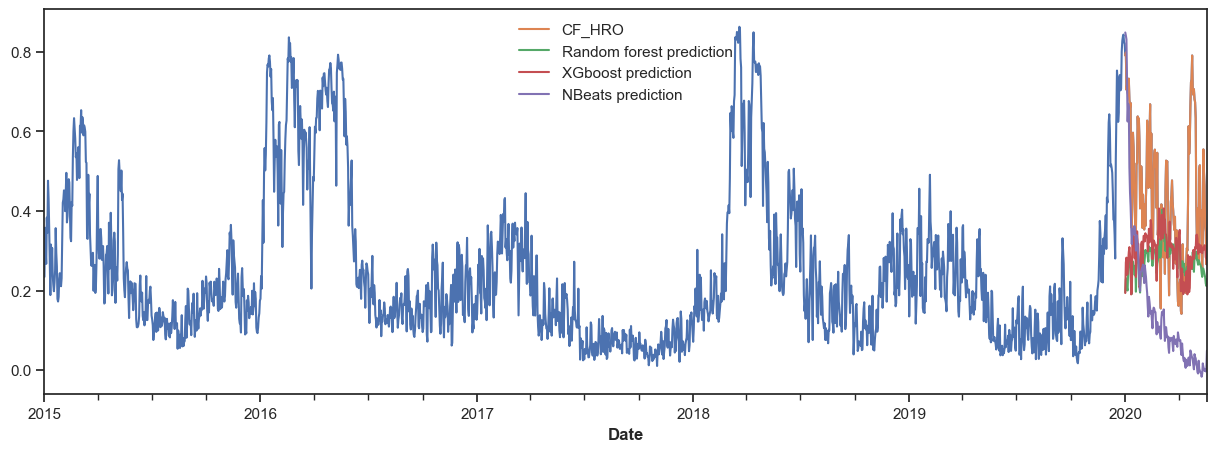

In [118]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
df_HRO['CF_HRO'].plot(ax=ax)
results.plot(ax=ax)
plt.show()

<AxesSubplot:xlabel='Date'>

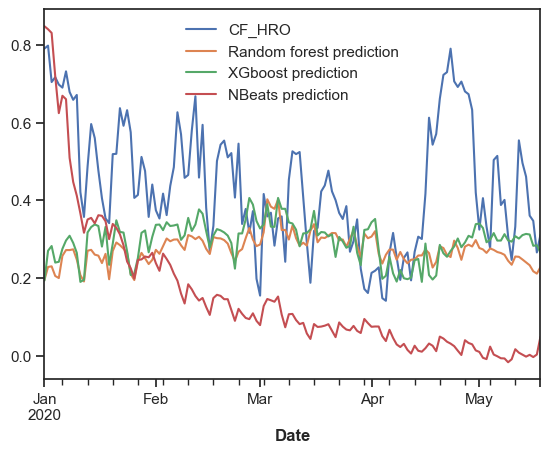

In [119]:
results.plot()